In [12]:
import sys
import os.path
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics
import keras.metrics
import keras.models
import keras.layers
import keras.optimizers
import keras.callbacks
import keras.utils.np_utils
import keras.preprocessing.sequence
import warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)

In [13]:
## Settings
do_knn = True
do_mlp = True
do_hg = True

merge_data = True
sn = 3
#usecols = ['id', 'cycle', 'comp_3', 'comp_4', 'comp_5', 'comp_6', 'comp_7', 'comp_8', 'comp_9', 'comp_10', 'status']
usecols = None
setnumber = 'FD00' + str(sn)
data_path = 'data'
plot_path = 'plots'
model_path = 'models'

## KNN settings
# range of n_neighbors
n_range = np.array(range(1, 20))

## MLP settings
dense_width = 8
dense_depth = 1
dropout = 0.2
bs = 1000 #batch size
epochs = 500
use_bias = False

In [14]:
# KNN tools
def make_knn(n, X_train, y_train, X_test, y_test):
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    return model

def make_prediction_knn(model, X_test, y_test, fig=False):
    y_pred = model.predict(X_test)
    aucs = np.array([])
    if fig:
        plt.figure()
    for i in range(y_pred.shape[1]):
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test[:,i], y_pred[:,i])
        auc = sklearn.metrics.auc(fpr, tpr)
        aucs = np.append(aucs, auc)
        if fig:
            plt.plot(fpr, tpr, label='RUL| %d (auc: %.2f) '%(i+1, auc))
    if fig:
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.legend()
        plt.show()
    return aucs, y_pred

In [15]:
## MLP tools
def make_mlp(train, X_train, dense_width, dense_depth, dropout):
    lw = X_train.shape[1]
    n_classes = train.status.nunique()
    print lw
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(dense_width, use_bias=use_bias, activation='relu', input_dim=lw))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.BatchNormalization())
    for i in range(dense_depth):
        model.add(keras.layers.Dense(dense_width, use_bias=use_bias, activation='relu'))
        model.add(keras.layers.Dropout(dropout))
        model.add(keras.layers.BatchNormalization())
    if n_classes == 2:
        model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    else:
        model.add(keras.layers.Dense(n_classes, activation='softmax'))
        sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy',
                      optimizer='sgd',
                      metrics=[keras.metrics.categorical_accuracy])
    return model

def make_hourglass(train, X_train, dense_width=10):
    lw = X_train.shape[1]
    n_classes = train.status.nunique()
    
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(dense_width, use_bias=use_bias, activation='relu', input_dim=lw))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(int(dense_width/2), use_bias=use_bias, activation='relu'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(int(dense_width/2), use_bias=use_bias, activation='relu'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.BatchNormalization())
    if n_classes == 2:
        model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    else:
        model.add(keras.layers.Dense(n_classes, activation='softmax'))
        sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy',
                      optimizer='sgd',
                      metrics=[keras.metrics.categorical_accuracy])
    return model

def fit_mlp(model, X_train, y_train, X_validate, y_validate, bs, epochs):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=bs, 
                        validation_data=(X_validate, y_validate), 
                        verbose=0, shuffle=True,
                        callbacks=[early_stopping])
    return history

def plot_model(history):
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    axs = axs.flatten()
    axs[0].plot(history.history['categorical_accuracy'], label='train')
    axs[0].plot(history.history['val_categorical_accuracy'], label='validation')
    axs[0].set_title('categorical_accuracy')
    axs[0].legend()
    axs[0].grid()
    axs[1].plot(history.history['loss'], label='train')
    axs[1].plot(history.history['val_loss'], label='validation')
    axs[1].set_title('loss')
    axs[1].legend()
    axs[1].grid()
    #axs[0].set_ylim(0.9, 1.0)
    #axs[1].set_ylim(0.0, 0.3)
    if merge_data:
        plt.savefig(os.path.join(plot_path, 'MLP_history_merge.png'))
    else:
        plt.savefig(os.path.join(plot_path, 'MLP_history_set.png'))
    plt.show()

In [16]:
## Shared tools
def make_prediction(model, X_test, y_test, fig=False):
    y_pred = model.predict(X_test)
    aucs = np.array([])
    if fig:
        plt.figure()
    for i in range(y_pred.shape[1]):
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test[:,i], y_pred[:,i])
        auc = sklearn.metrics.auc(fpr, tpr)
        aucs = np.append(aucs, auc)
        if fig:
            plt.plot(fpr, tpr, label='RUL %d (auc: %.2f) '%(i+1, auc))
    if fig:
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.legend()
        plt.grid()
        plt.show()
    return aucs, y_pred

def prepare_data(usecols):
    ## Read preprocessed data
    if merge_data:
        full = pd.read_csv(os.path.join(data_path, 'full_'+setnumber+'_PC_merge.csv'))
        train = pd.read_csv(os.path.join(data_path, 'train_'+setnumber+'_PC_merge.csv'), usecols=usecols)
        test = pd.read_csv(os.path.join(data_path, 'test_'+setnumber+'_PC_merge.csv'), usecols=usecols)
        validate = pd.read_csv(os.path.join(data_path, 'validate_'+setnumber+'_PC_merge.csv'), usecols=usecols)
    else:
        full = pd.read_csv(os.path.join(data_path, 'full_'+setnumber+'_PC.csv'), usecols=usecols)    
        train = pd.read_csv(os.path.join(data_path, 'train_'+setnumber+'_PC.csv'), usecols=usecols)
        test = pd.read_csv(os.path.join(data_path, 'test_'+setnumber+'_PC.csv'), usecols=usecols)
        validate = pd.read_csv(os.path.join(data_path, 'validate_'+setnumber+'_PC.csv'), usecols=usecols)
    if 'RUL' in train.columns:
        train.drop('RUL', 1, inplace=True)
        test.drop('RUL', 1, inplace=True)
        validate.drop('RUL', 1, inplace=True)    
    ## Encode labels to integers
    le = sklearn.preprocessing.LabelEncoder().fit(full.status)
    full['status'] = le.transform(full.status)
    train['status'] = le.transform(train.status)
    test['status'] = le.transform(test.status)
    validate['status'] = le.transform(validate.status)
    ## Split feature-label arrays
    X_full = full[full.columns.difference(['id', 'cycle', 'status'])].values
    y_full = keras.utils.np_utils.to_categorical(full['status'].values)

    X_train = train[train.columns.difference(['id', 'cycle', 'status'])].values
    y_train = keras.utils.np_utils.to_categorical(train['status'].values)

    X_validate = validate[validate.columns.difference(['id', 'cycle', 'status'])].values
    y_validate = keras.utils.np_utils.to_categorical(validate['status'].values)

    X_test = test[test.columns.difference(['id', 'cycle', 'status'])].values
    y_test = keras.utils.np_utils.to_categorical(test['status'].values)    
    
    print X_train.shape, X_validate.shape, X_test.shape
    return X_train, y_train, X_test, y_test, X_validate, y_validate, train, test, validate

In [17]:
X_train, y_train, X_test, y_test, X_validate, y_validate, train, test, validate = prepare_data(usecols)

(24789, 15) (8263, 15) (8264, 15)


In [18]:
print train.shape, X_train.shape, y_train.shape
print y_train

(24789, 18) (24789, 15) (24789, 4)
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]]


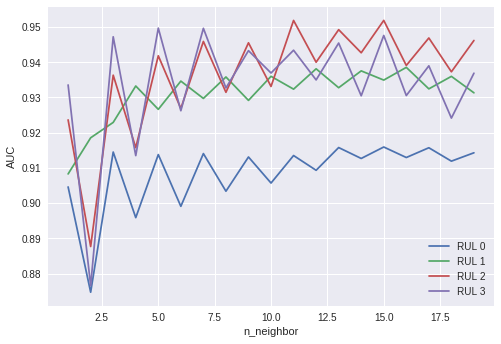

In [19]:
## KNN
if do_knn:
    aucs = np.zeros((len(n_range), y_test.shape[1]))
    for i, n in enumerate(n_range):
        KNN_model = make_knn(n, X_train, y_train, X_test, y_test)
        aucs[i,:], y_pred = make_prediction(KNN_model, X_test, y_test, fig=False)
    colors = ['b', 'g', 'r', 'm']
    plt.figure()
    for l in range(y_test.shape[1]):
        plt.plot(n_range, aucs[:,l], label='RUL %d'%l)
    plt.legend()
    plt.xlabel('n_neighbor')
    plt.ylabel('AUC')
    plt.show()

In [20]:
## MLP
if do_mlp:
    MLP_model = make_mlp(train, X_train, dense_width, dense_depth, dropout)
    history = fit_mlp(MLP_model, X_train, y_train, X_validate, y_validate, bs, epochs)
    MLP_model.save(os.path.join(model_path, 'MLP_model_%s_%d_%d_%.1f.h5'%(setnumber, dense_width, dense_depth, dropout)))

15


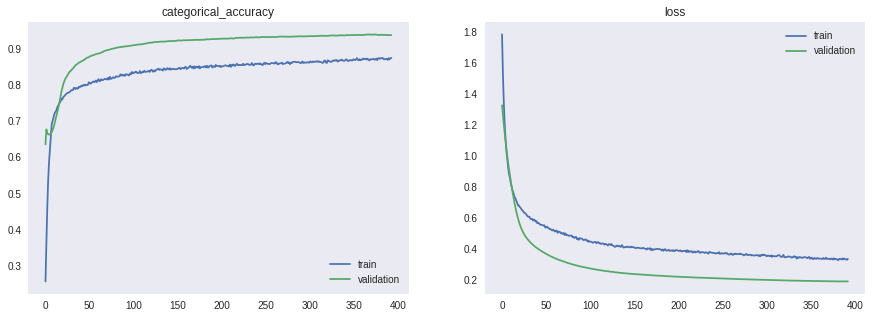

In [21]:
if do_mlp:
    MLP_auc = plot_model(history)

In [22]:
## Hourglass
if do_hg:
    hg_model = make_hourglass(train, X_train)
    hg_hist = fit_mlp(hg_model, X_train, y_train, X_validate, y_validate, bs, epochs)
    hg_model.save(os.path.join(model_path, 'hg_model_%s.h5'%(setnumber)))

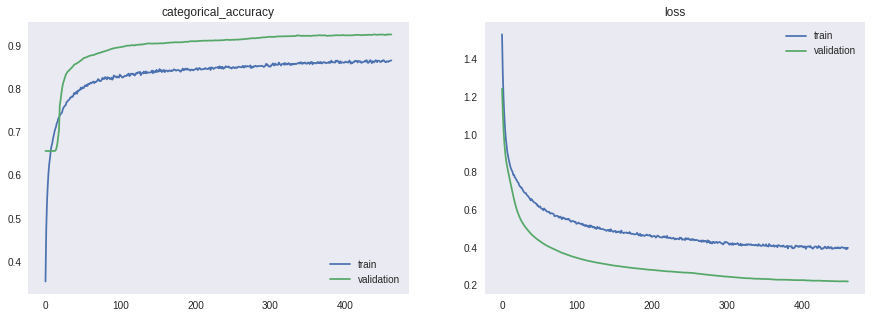

In [23]:
if do_hg:
    hg_auc = plot_model(hg_hist)

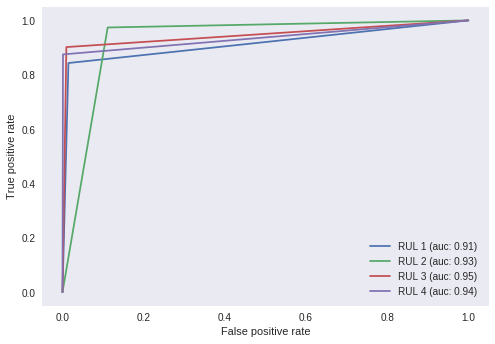

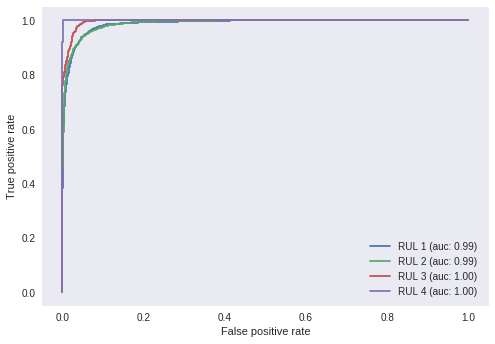

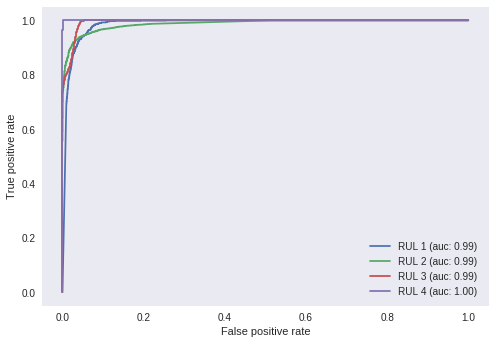

In [24]:
if do_knn:
    aucs, y_pred_knn = make_prediction(KNN_model, X_test, y_test, fig=True)
if do_mlp:
    aucs, y_pred_mlp = make_prediction(MLP_model, X_test, y_test, fig=True)
if do_hg:
    aucs, y_pred_hg = make_prediction(hg_model, X_test, y_test, fig=True)

In [25]:
y_knn = y_pred_knn
print (sklearn.metrics.classification_report(y_test, y_knn))

             precision    recall  f1-score   support

          0       0.91      0.84      0.87      1218
          1       0.94      0.97      0.96      5346
          2       0.95      0.90      0.93      1468
          3       0.95      0.88      0.91       232

avg / total       0.94      0.94      0.94      8264



In [26]:
y_mlp = keras.utils.np_utils.to_categorical(np.array([np.argmax(y_pred_mlp[i]) for i in range(len(y_pred_mlp))]),
                                            num_classes=train.status.nunique())
print (sklearn.metrics.classification_report(y_test, y_mlp))

             precision    recall  f1-score   support

          0       0.90      0.81      0.85      1218
          1       0.94      0.98      0.96      5346
          2       0.90      0.94      0.92      1468
          3       1.00      0.34      0.51       232

avg / total       0.93      0.93      0.92      8264



In [27]:
y_hg = keras.utils.np_utils.to_categorical(np.array([np.argmax(y_pred_hg[i]) for i in range(len(y_pred_hg))]), 
                                           num_classes=train.status.nunique())
print (sklearn.metrics.classification_report(y_test, y_hg))

             precision    recall  f1-score   support

          0       0.82      0.90      0.86      1218
          1       0.96      0.95      0.96      5346
          2       0.86      0.94      0.90      1468
          3       1.00      0.08      0.15       232

avg / total       0.92      0.92      0.91      8264



In [28]:
precision_knn, recall_knn, f1_knn, support_knn = sklearn.metrics.precision_recall_fscore_support(y_test, y_knn)
precision_mlp, recall_mlp, f1_mlp, support_mlp = sklearn.metrics.precision_recall_fscore_support(y_test, y_mlp)
precision_hg, recall_hg, f1_hg, support_hg = sklearn.metrics.precision_recall_fscore_support(y_test, y_hg)

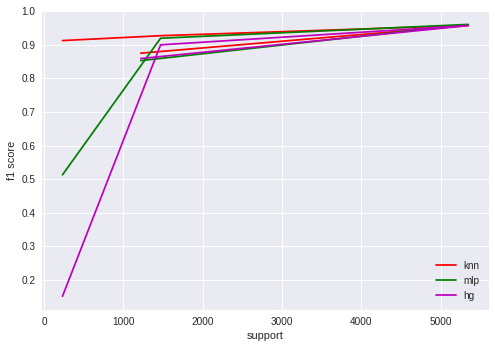

In [29]:
plt.plot(support_knn, f1_knn, '-r', label='knn')
plt.plot(support_mlp, f1_mlp, '-g', label='mlp')
plt.plot(support_hg, f1_hg, '-m', label='hg')
plt.legend()
plt.xlabel('support')
plt.ylabel('f1 score')
plt.show()